In [1]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

In [2]:
def plot_spect(sig, fs, window='nuttall', noverlap=256*8*2, nperseg=512*8*2, nfft=2048*16*8):
    f, t, Sxx = scipy.signal.spectrogram(sig, fs=fs, window='nuttall',
                                     noverlap=256*8, nperseg=512*8,
                                     nfft=2048*16*8*2*4)
    plt.pcolormesh(f, t, Sxx.T)
    plt.ylabel('time')
    plt.xlabel('freq')
    plt.show()

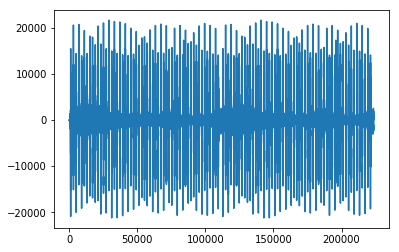

In [3]:
noise = np.array(scipy.io.wavfile.read('./data/iono-othr1.wav')[1], dtype=np.float)
noise = np.concatenate([noise, noise])
plt.plot(noise)
plt.show()

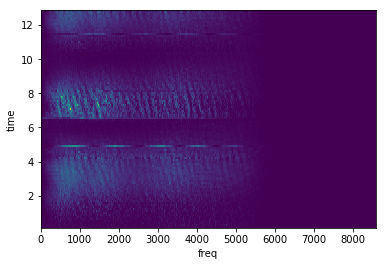

In [4]:
T = 13
fs = float(len(noise)) / T
plot_spect(noise, fs)

/home/rytse/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


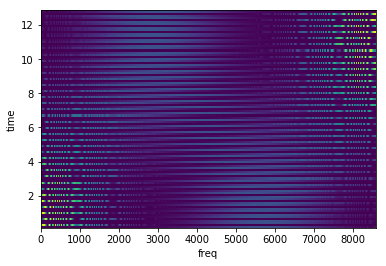

In [5]:
ts = np.linspace(0, T, T*fs, endpoint=False)
chirp = scipy.signal.chirp(ts, f0=2e6, t1=128*16, f1=100e6, method='linear')
sig = chirp.copy() #+ noise * 1e-10
plot_spect(chirp, fs)

/home/rytse/anaconda3/envs/irss/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


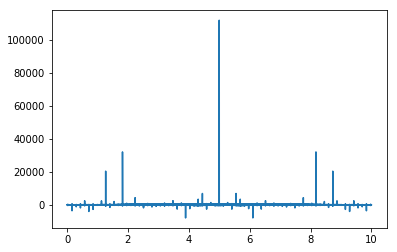

In [6]:
delayed = chirp.copy()
delayed = np.array([0] * 600 + list(delayed[600:]))

cor = scipy.signal.correlate(sig, sig)#delayed)
plt.plot(np.linspace(0, 10, len(cor)), cor)
plt.show()